# 3. Make a Hypothesis

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.optimize import curve_fit
from scipy import stats
import seaborn as sns
from sklearn.metrics import roc_auc_score

In [2]:
# Load the data
data = pd.read_csv("data.csv")
subjects = pd.read_csv("subjectInfo.csv")

# Check for missing values
print("Missing values in data:")
print(data.isna().sum())

data = data.dropna()

Missing values in data:
trialKeys        0
levelFreq        0
levelFace        0
lCueName         0
rCueName         0
srespLoc       548
srespChoice    548
RT             548
Hand             0
blockType        0
subjectId        0
dtype: int64


In [5]:
def stat_test(data, parametric_test, nonparametric_test, alternative=None, alpha=0.05):
    # Normality check
    p_normal = all(stats.shapiro(group)[1] >= alpha for group in data)
    
    # Choose test based on normality
    if p_normal >= alpha:
        test_name = parametric_test.__name__
        test = parametric_test
    else:
        test_name = nonparametric_test.__name__
        test = nonparametric_test
    
    if alternative:
        result = test(*data, alternative=alternative)
    else:
        result = test(*data)
        
    print(f"{test_name}: statistic = {result.statistic:.1f}, p-value = {result.pvalue:.4f}")

In [14]:
def plot_violin(data, xlabel, name, test_type):
    sns.violinplot(data=data)
    plt.xlabel(xlabel)
    plt.ylabel('Beta')
    plt.title(name)
    plt.savefig(f"{test_type} violin_plot {xlabel}.pdf", bbox_inches="tight", dpi=300, metadata={'Date': None})

### 3.1 Psychometric Fitting

In [4]:
def sigmoid(x, alpha, beta):
    return alpha / (1 + np.exp(-beta * x))

def fit_model(x, y, model_func=sigmoid, p0=[1.0, 1.0]):
    popt, _ = curve_fit(model_func, x, y, p0=p0, maxfev=1000000)
    return popt

def fit_psychometric(data, model_func=sigmoid, p0=[1.0, 1.0]):
    proportions = data.groupby('levelFace')['srespChoice'].apply(lambda x: np.mean(
        x.isin(['Hasan', 'Goli']))).reset_index(name='proportion')
    
    x = proportions['levelFace'].values
    y = proportions['proportion'].values

    return fit_model(x, y, model_func, p0)

In [7]:
def calculate_beta(data, cond_key=None):
    betas_dict = defaultdict(list)

    for sid in data['subjectId'].unique():
        sub_data = data[data['subjectId'] == sid]
        betas_dict[('subjectId', '') if cond_key else 'subjectId'].append(sid)

        for pair in sub_data['trialKeys'].unique():
            if cond_key is None:
                subset = sub_data[sub_data['trialKeys'] == pair]
                _, beta = fit_psychometric(subset)
                betas_dict[pair].append(beta)
            else:
                for cond_value in data[cond_key].unique():
                    subset = sub_data[(sub_data['trialKeys'] == pair) & (sub_data[cond_key] == cond_value)]
                    _, beta = fit_psychometric(subset)
                    betas_dict[(pair, cond_value)].append(beta)
                    
    return pd.DataFrame(betas_dict)

Beta AbHa wilcoxon: statistic = 182.0, p-value = 0.0054
Beta MahGol wilcoxon: statistic = 173.0, p-value = 0.0035


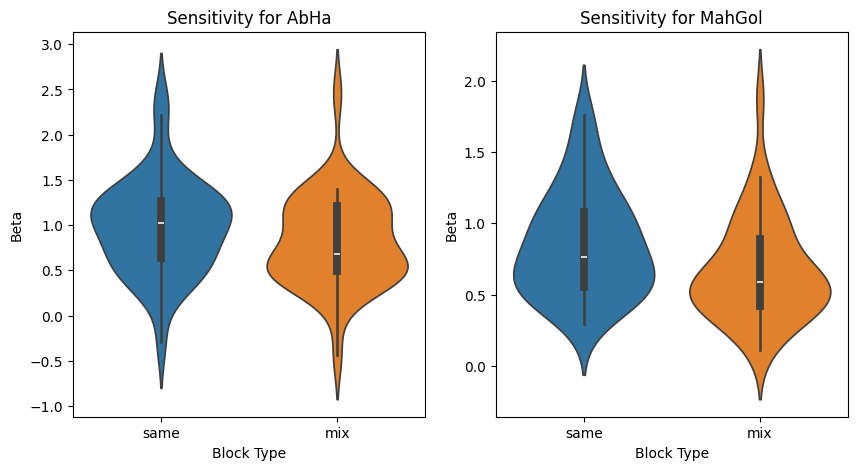

In [22]:
pivot_block = calculate_beta(data, 'blockType')

plt.figure(figsize=(10, 5))
for i, pair in enumerate(['AbHa', 'MahGol']):
    print("Beta", pair, end=' ')
    stat_test(pivot_block[pair].values.T, stats.ttest_rel, stats.wilcoxon)
    plt.subplot(1, 2, i + 1)
    plot_violin(pivot_block[pair], "Block Type", f"Sensitivity for {pair}", "Beta")

### 3.2 Receptive Operating Curve (ROC)

In [9]:
def compute_roc(data):
    data = data[data['levelFace'] != 0]

    true_labels = data['levelFace'] > 0  # Positive levels mean 'Hasan'
    predictions = data['srespChoice'].isin(['Hasan', 'Goli'])

    return roc_auc_score(true_labels, predictions)

In [10]:
def compute_separability(data, cond_key=None):
    aucs_dict = defaultdict(list)

    for sid in data['subjectId'].unique():
        sub_data = data[data['subjectId'] == sid]
        aucs_dict[('subjectId', '') if cond_key else 'subjectId'].append(sid)

        for pair in sub_data['trialKeys'].unique():
            if cond_key is None:
                subset = sub_data[sub_data['trialKeys'] == pair]
                auc = compute_roc(subset)
                aucs_dict[pair].append(auc)
            else:
                for cond_value in data[cond_key].unique():
                    subset = sub_data[(sub_data['trialKeys'] == pair) & (sub_data[cond_key] == cond_value)]
                    auc = compute_roc(subset)
                    aucs_dict[(pair, cond_value)].append(auc)

    return pd.DataFrame(aucs_dict)

ROC AbHa wilcoxon: statistic = 160.0, p-value = 0.0017
ROC MahGol ttest_rel: statistic = 1.8, p-value = 0.0785


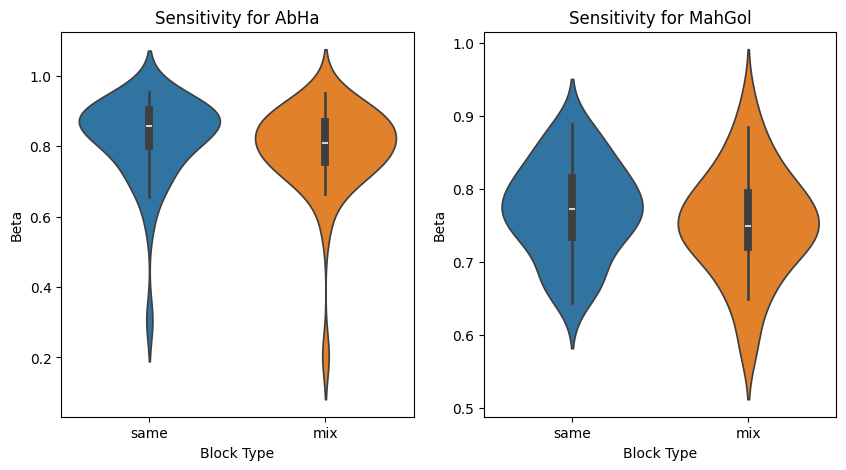

In [23]:
pivot_block = compute_separability(data, 'blockType')

plt.figure(figsize=(10, 5))
for i, pair in enumerate(['AbHa', 'MahGol']):
    print("ROC", pair, end=' ')
    stat_test(pivot_block[pair].values.T, stats.ttest_rel, stats.wilcoxon)
    plt.subplot(1, 2, i + 1)
    plot_violin(pivot_block[pair], "Block Type", f"Sensitivity for {pair}", "ROC")